In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

# Step 1: Generate example data
num_train_examples = 20000
sequence_length = 8

batch_size = 64
num_epochs = 25
val_split = 0.2

rng = np.random.default_rng(2024)

In [17]:
# Generate random frequencies for sine waves
# we'll use 1.0 as the maximum Nyquist frequency and 0 = constant
frequencies = rng.uniform(0.02, 0.2, size=num_train_examples)
phase_offsets = rng.uniform(0.0, 2*np.pi, size=num_train_examples)
sequences = np.zeros((num_train_examples, sequence_length))

# Generate sine waves
for i in range(num_train_examples):
    sequences[i] = np.sin(2*np.pi*frequencies[i]* np.arange(sequence_length) + phase_offsets[i])

# Split sequences into input (first <sequence_length-1> elements) and labels (sequence_length>'th element)
x_train = sequences[:, :sequence_length-1]
y_train = sequences[:, sequence_length-1]


In [18]:
# Build the model
model = models.Sequential([
  layers.InputLayer(input_shape=x_train.shape[1:]), 
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(1)  # Single neuron for regression
])

# Compile the model
steps_per_epoch = int((1.0-val_split)*num_train_examples / batch_size)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-2, steps_per_epoch*num_epochs)
  
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule), # use tf.keras.optimizers.Adam on Intel / NVidia GPU
              loss='mean_squared_error'
             )

In [19]:
# Train the model
train_hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=val_split)

Epoch 1/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0648 - val_loss: 0.1145
Epoch 2/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0089
Epoch 3/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0179 - val_loss: 0.0035
Epoch 4/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0137 - val_loss: 0.0028
Epoch 5/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0134 - val_loss: 0.0022
Epoch 6/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0038
Epoch 7/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0046
Epoch 8/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0040
Epoch 9/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0030
Epoch 10/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0027

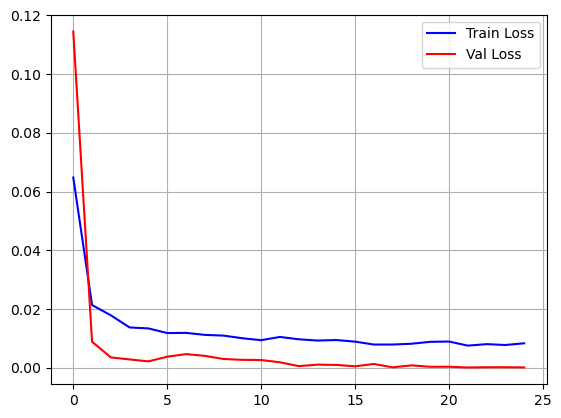

In [20]:
plt.plot(train_hist.epoch, train_hist.history['loss'], 'b-', label='Train Loss')
plt.plot(train_hist.epoch, train_hist.history['val_loss'], 'r-', label='Val Loss')
        

        
plt.legend()
plt.grid(True)

In [21]:
loss = model.evaluate(x_train, y_train)
print("Final training loss:", loss)

625/625 [==============================] - 1s 1ms/step - loss: 1.2059e-04
Final training loss: 0.00012058926949976012


625/625 [==============================] - 1s 859us/step


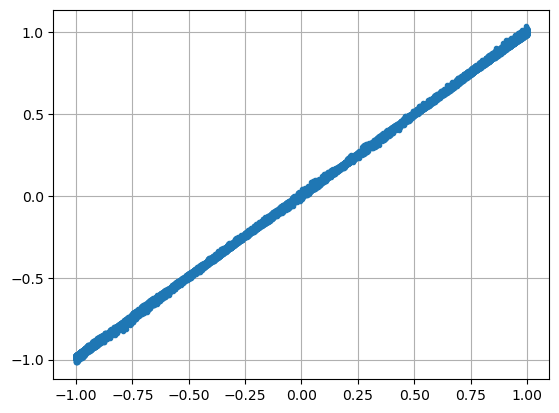

In [22]:
y_pred = model.predict(x_train)
plt.plot(y_train, y_pred, '.')
plt.grid(True)

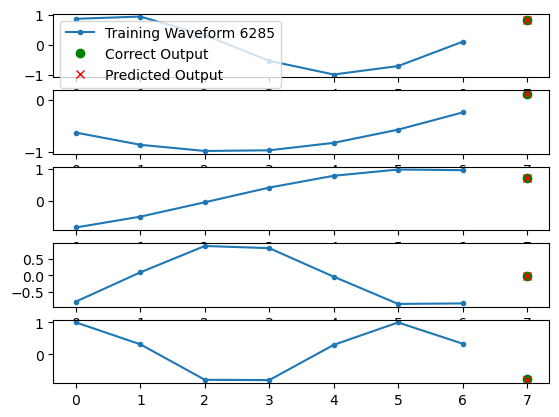

In [23]:
num_to_plot = 5
for i in range(5):
  plt.subplot(num_to_plot,1,i+1)
  index = rng.integers(low=0, high=num_train_examples)
  plt.plot(np.arange(sequence_length-1), x_train[i,:], '.-', 
           sequence_length-1, y_train[i], 'go',
           sequence_length-1, y_pred[i], 'rx'
          )
  if i == 0:
    # the legend obscures the data, so just show it once
    plt.legend([f"Training Waveform {index}", "Correct Output", "Predicted Output"])

In [24]:
model.save("sin_predictor.h5")

In [25]:
model = tf.keras.models.load_model("sin_predictor.h5")

# Function to generate representative data for quantization
def representative_dataset():
    for _ in range(100):
        data = np.random.uniform(-128, 127, size=(1, 7)).astype(np.float32)  # Match int8 range
        yield [data]


# Convert the model to TFLite with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  
converter.inference_output_type = tf.int8  

# Convert and save the model
tflite_model = converter.convert()
with open("sin_predictor.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\legon\AppData\Local\Temp\tmpzg3j3tzb\assets


INFO:tensorflow:Assets written to: C:\Users\legon\AppData\Local\Temp\tmpzg3j3tzb\assets
c:\Users\legon\miniconda3\envs\IOTenv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
